# Exercise 2
Using your select stock / market index and your decision criterion (binary or ternary) on the daily return of the next day or on the trend (daily return after 5/10 days), can you generate a 1R model using as possible predictor the volume, and the moving average (with a period of 5, 10, 20 50 or 200). You can learn on all days except the last 100 (that will be used as the test set).

In [60]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
IBM = pd.read_csv('../Data/IBM.txt.zst', delimiter=' ')
IBM['Date'] = IBM['Date'].apply(pd.to_datetime)
IBM.head(5)

,Date,Open,High,Low,Close,Volume,Adjusted
0,2007-01-03,97.180000,98.400002,96.260002,97.269997,9196800,63.127567
1,2007-01-04,97.250000,98.790001,96.879997,98.309998,10524500,63.802544
2,2007-01-05,97.599998,97.949997,96.910004,97.419998,7221300,63.224930
3,2007-01-08,98.500000,99.500000,98.349998,98.900002,10340000,64.185463
4,2007-01-09,99.080002,100.330002,99.070000,100.070000,11108200,64.944771


In [61]:
IBM.describe(include='all', datetime_is_numeric=True)

,Date,Open,High,Low,Close,Volume,Adjusted
count,3692,3692.000000,3692.000000,3692.000000,3692.000000,3.692000e+03,3692.000000
mean,2014-05-02 11:46:20.931744256,147.198976,148.403180,146.074512,147.269085,5.576247e+06,113.375997
min,2007-01-03 00:00:00,72.739998,76.980003,69.500000,71.739998,1.027500e+06,48.040176
25%,2010-08-31 18:00:00,124.189999,125.349998,123.072502,124.332496,3.482300e+06,90.296511
50%,2014-05-03 12:00:00,144.750000,145.619995,143.830002,144.730003,4.653750e+06,120.980629
75%,2017-12-30 00:00:00,168.847500,170.442501,167.659996,169.169998,6.660725e+06,132.155647
max,2021-08-31 00:00:00,215.380005,215.899994,214.300003,215.800003,3.806350e+07,155.979538
std,NaN,30.808862,30.780935,30.844083,30.796603,3.229710e+06,25.410689


We compute the `Daily Returns` as according to the formular:
$r_{t+1} = \frac{p_{t+1} - p_t}{p_t}$

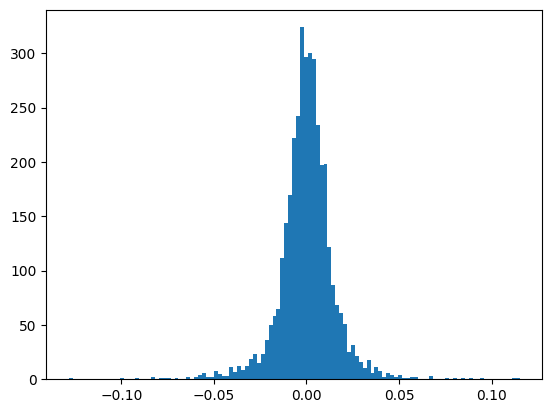

In [62]:
import numpy as np
import matplotlib.pyplot as plt

daily_returns = np.empty(IBM['Close'].shape)
daily_returns[0] = float('NaN')
daily_returns[1:] = np.ediff1d(IBM['Close']) / IBM['Close'][:-1]
IBM['Daily Returns'] = daily_returns

num_bins = int(len(daily_returns) / 32)
plt.hist(daily_returns, bins=num_bins)
plt.show()

Next we compute the `Binary Decision` (up/down) and the `Ternary decision` (up/flat/down).

In [63]:
binary_decision = (daily_returns > 0).astype(float)
binary_decision[0] = float('NaN')
IBM['Binary Decision'] = binary_decision

CUTOFF = 0.005
ternary_decision = np.zeros(daily_returns.shape)
ternary_decision[np.where(daily_returns > CUTOFF)] = 1
ternary_decision[np.where(daily_returns < CUTOFF)] = -1
ternary_decision[0] = float('NaN')
IBM['Ternary Decision'] = ternary_decision

And we compute the simple moving average (SMA).

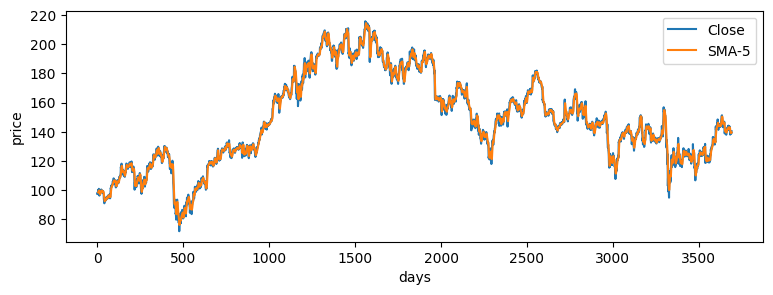

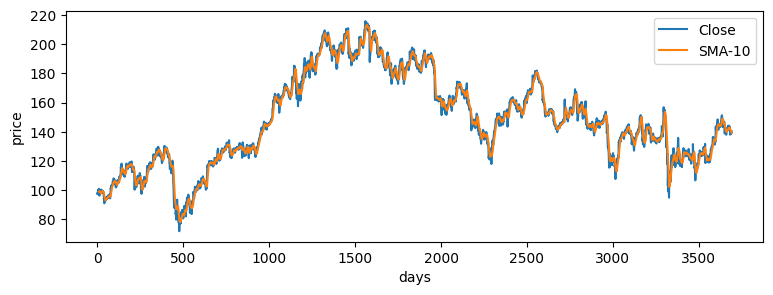

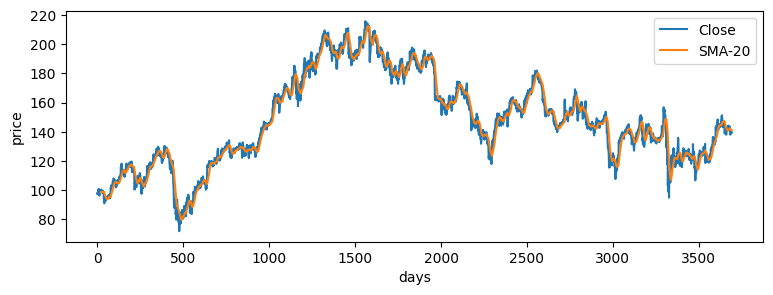

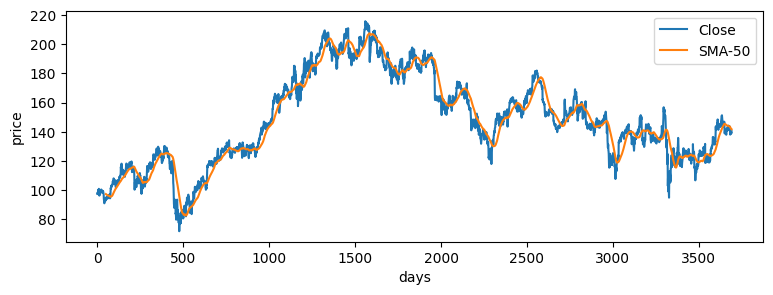

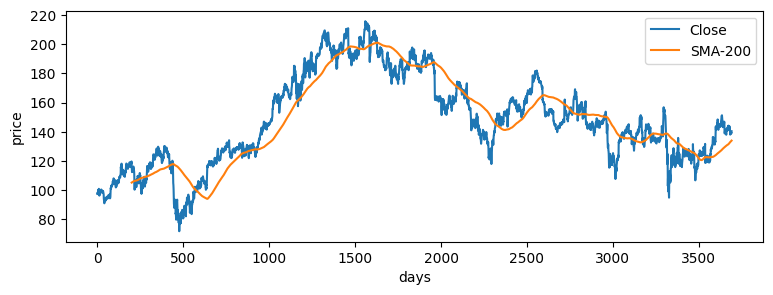

In [64]:
for period in [5, 10, 20, 50, 200]:
    label = 'SMA-{}'.format(period)
    IBM[label] = IBM['Close'].rolling(period).mean()
    IBM[['Close', label]].plot(label=label, figsize=(9, 3), xlabel='days', ylabel='price')

In [65]:
IBM.head(5)

,Date,Open,High,Low,Close,Volume,Adjusted,Daily Returns,Binary Decision,Ternary Decision,SMA-5,SMA-10,SMA-20,SMA-50,SMA-200
0,2007-01-03,97.180000,98.400002,96.260002,97.269997,9196800,63.127567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,97.250000,98.790001,96.879997,98.309998,10524500,63.802544,0.010692,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2007-01-05,97.599998,97.949997,96.910004,97.419998,7221300,63.224930,-0.009053,0.0,-1.0,NaN,NaN,NaN,NaN,NaN
3,2007-01-08,98.500000,99.500000,98.349998,98.900002,10340000,64.185463,0.015192,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,2007-01-09,99.080002,100.330002,99.070000,100.070000,11108200,64.944771,0.011830,1.0,1.0,98.393999,NaN,NaN,NaN,NaN


The possible rules for `One-R` for either one or two features are:

In [66]:
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import accuracy_score
from mlxtend.classifier import OneRClassifier
from typing import Iterable


def start_index(x: str) -> int:
    match x:
        case 'Binary Decision' | 'Ternary Decision':
            return 1
        case 'SMA-5':
            return 5
        case 'SMA-10':
            return 10
        case 'SMA-20':
            return 20
        case 'SMA-50':
            return 50
        case 'SMA-200':
            return 200
        case _:
            return 0


def train_and_predict(X_idx: Iterable[str], y_idx: str) -> float:
    start_idx = max(start_index(y_idx), max(map(start_index, X_idx)))
    X = IBM[X_idx][start_idx:]
    y = IBM[y_idx][start_idx:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100 / X.shape[0], shuffle=False)

    one_r = OneRClassifier()
    one_r.fit(X_train.to_numpy(), y_train)

    y_pred = one_r.predict(X_test.to_numpy())
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [67]:
rules = [a for a in IBM.columns if a != 'Date' and a != 'Binary Decision' and a != 'Ternary Decision']
rules2 = [[a, b] for a in rules for b in rules if rules.index(a) < rules.index(b)]

We try all rules to see which one fits the best in a `One-R` model.

In [68]:
all_one_r = pd.DataFrame(
    map(lambda rule: [rule, train_and_predict(X_idx=[rule], y_idx='Binary Decision')], rules),
    columns=["Rule", "Accuracy"],
)

all_one_r

,Rule,Accuracy
0,Open,0.40
1,High,0.42
2,Low,0.52
3,Close,0.47
4,Volume,0.43
5,Adjusted,0.45
6,Daily Returns,0.45
7,SMA-5,0.45
8,SMA-10,0.44
9,SMA-20,0.45


In [69]:
best_one_r = all_one_r[all_one_r.Accuracy == all_one_r.Accuracy.max()]

print("Best 1R:")
best_one_r

Best 1R:


,Rule,Accuracy
2,Low,0.52
